# CompositionDE - Compositional analysis of single-cell data



This notebook serves as a tutorial for using the *SCDCdm* package to analyze changes in cell composition data.

The package is intended to be used with data coming from single-cell RNA-seq experiments, however there are no 
restrictions that prevent the use of data from other sources.

The data we use in the following example comes from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489).
It contains samples from the small intestinal epithelium of mice with different conditions.


In [1]:
# Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import warnings

from scdcdm.util import comp_ana as mod
from scdcdm.util import cell_composition_data as dat

warnings.filterwarnings("ignore")

C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Data preparation

In [2]:
# Load data

cell_counts = pd.read_csv("C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\compositionalDiff-johannes_tests_2\\data\\haber_counts.csv")

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

Looking at the data, we see that we have 4 control samples, and 3 conditions with 2 samples each. 
To use the models in *SCDCdm*, we first have to convert the data into an [anndata](https://github.com/theislab/anndata) object.
This object separates our data components: Cell counts are stored in `data.X`, covariates in `data.obs`.

For our first example, we want to look at how the Salmonella infection influences the cell composition.



In [3]:
# Convert data to anndata object

# Filter out control and salmonella data
salm_indices = [0, 1, 2, 3, 8, 9]
salm_df = cell_counts.iloc[salm_indices, :]

# Convert to a CompositionalData object
data_salm = dat.from_pandas(salm_df, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_salm.obs["Condition"] = data_salm.obs["Mouse"].str.replace(r"_[0-9]", "")
print(data_salm.X)
print(data_salm.obs)

Transforming to str index.


[[ 36.  59. 136.  36. 239. 125. 191.  18.]
 [  5.  46.  23.  20.  50.  11.  40.   5.]
 [ 45.  98. 188. 124. 250. 155. 365.  33.]
 [ 26. 221. 198.  36. 131. 130. 196.   4.]
 [ 37. 332. 113.  59.  90.  47. 132.  10.]
 [ 32. 373. 116.  67. 117.  65. 168.  12.]]
       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


Plotting the data, we can see that there is a large increase of Enterocytes in the infected sampes, while most other cell types slightly decrease.
Since scRNA-seq experiments are limited in the number of cells per sample, the count data is compositional, which leads to negative correlations between the cell types.
Thus, the slight decreases in many cell types might be fully caused by the increase in Enterocytes.

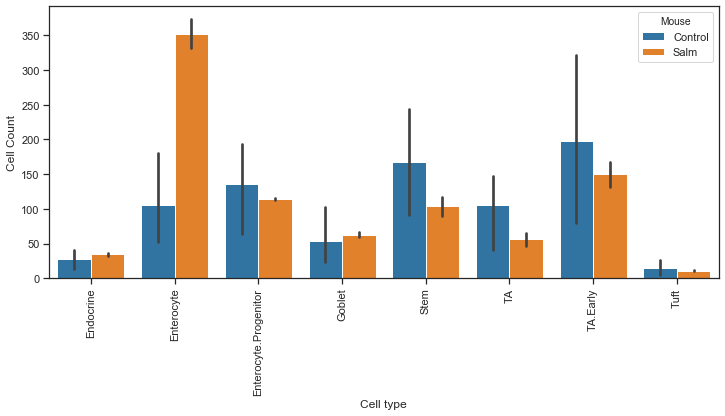

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
df = pd.melt(salm_df, id_vars=['Mouse'], value_vars=salm_df.columns[1:])
sns.set_context('notebook')
sns.set_style('ticks')
d = sns.barplot(x='variable', y = 'value', hue=df["Mouse"].str.replace(r"_[0-9]", ""), data=df)
d.set_ylabel('Cell Count')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
plt.show()

*Note that the use of* anndata *in* SCDCdm *is different from the use in scRNA-seq pipelines, e.g.* scanpy. 
*To convert* scanpy *objects to a SCDCdm dataset, have a look at `dat.from_scanpy_list`.*

### Model setup and inference

We can now create the model and run inference on it. The `mod.CompositionalAnalysis` class takes our data object and performs parameter inference on it.

The `formula` parameter specifies which covariates are used in the inference. It can process R-style formulas via the [patsy](https://github.com/pydata/patsy/blob/master/doc/index.rst) package, e.g. `formula="Cov1 + Cov2 + Cov3"`.

The `baseline_index` parameter is used to specify a cell type that is left unchanged by the covariates.
This feature is optional, a baseline index of `None` specifies the model without baseline specification.

In [17]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", baseline_index=None)

In [18]:
# Run MCMC
sim_results = model_salm.sample_hmc()
sim_results.summary()


MCMC sampling finished. (154.637 sec)
Acceptance rate: 56.1%
Compositional Analysis summary:
Intercepts:
                       Final Parameter  HPD 3%  HPD 97%     SD  \
Cell Type                                                        
Endocrine                        1.104   0.326    1.762  0.389   
Enterocyte                       2.357   1.762    2.928  0.313   
Enterocyte.Progenitor            2.564   1.990    3.186  0.316   
Goblet                           1.710   1.015    2.318  0.346   
Stem                             2.737   2.148    3.277  0.305   
TA                               2.151   1.527    2.739  0.327   
TA.Early                         2.903   2.311    3.457  0.311   
Tuft                             0.433  -0.402    1.126  0.412   

                       Expected Sample  
Cell Type                               
Endocrine                    33.183680  
Enterocyte                  116.170412  
Enterocyte.Progenitor       142.887582  
Goblet                       

The "Final parameter" column for the Effects tells us, which cell types change significantly. 
If the value is zero, no significant effect was detected. 
For a value other than zero, a significant change was detected. A positive sign indicates an increase, a negative sign a decrease.

The "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of this increase. 
If we assume equal total cell counts for control and infected samples, the Expected samples for intercepts and slopes represent the mean samples that were found by the SCDCdm model for both cases 
(intercepts <=> control; slopes <=> disease). 
The log-fold change is then calculated between these columns.
Since the data is compositional, all unaffected cell types are expected to change as well.

In the salmonella case, we see only a significant increase of Enterocytes, while all other cell types are unaffected by the disease.
The log-fold change of Enterocytes between control and infected samples with the same total cell count lies at about 1.54.


### Diagnostics and plotting

For further analysis, the results object supports all plotting and diagnosis functions of [arviz](https://github.com/arviz-devs/arviz).


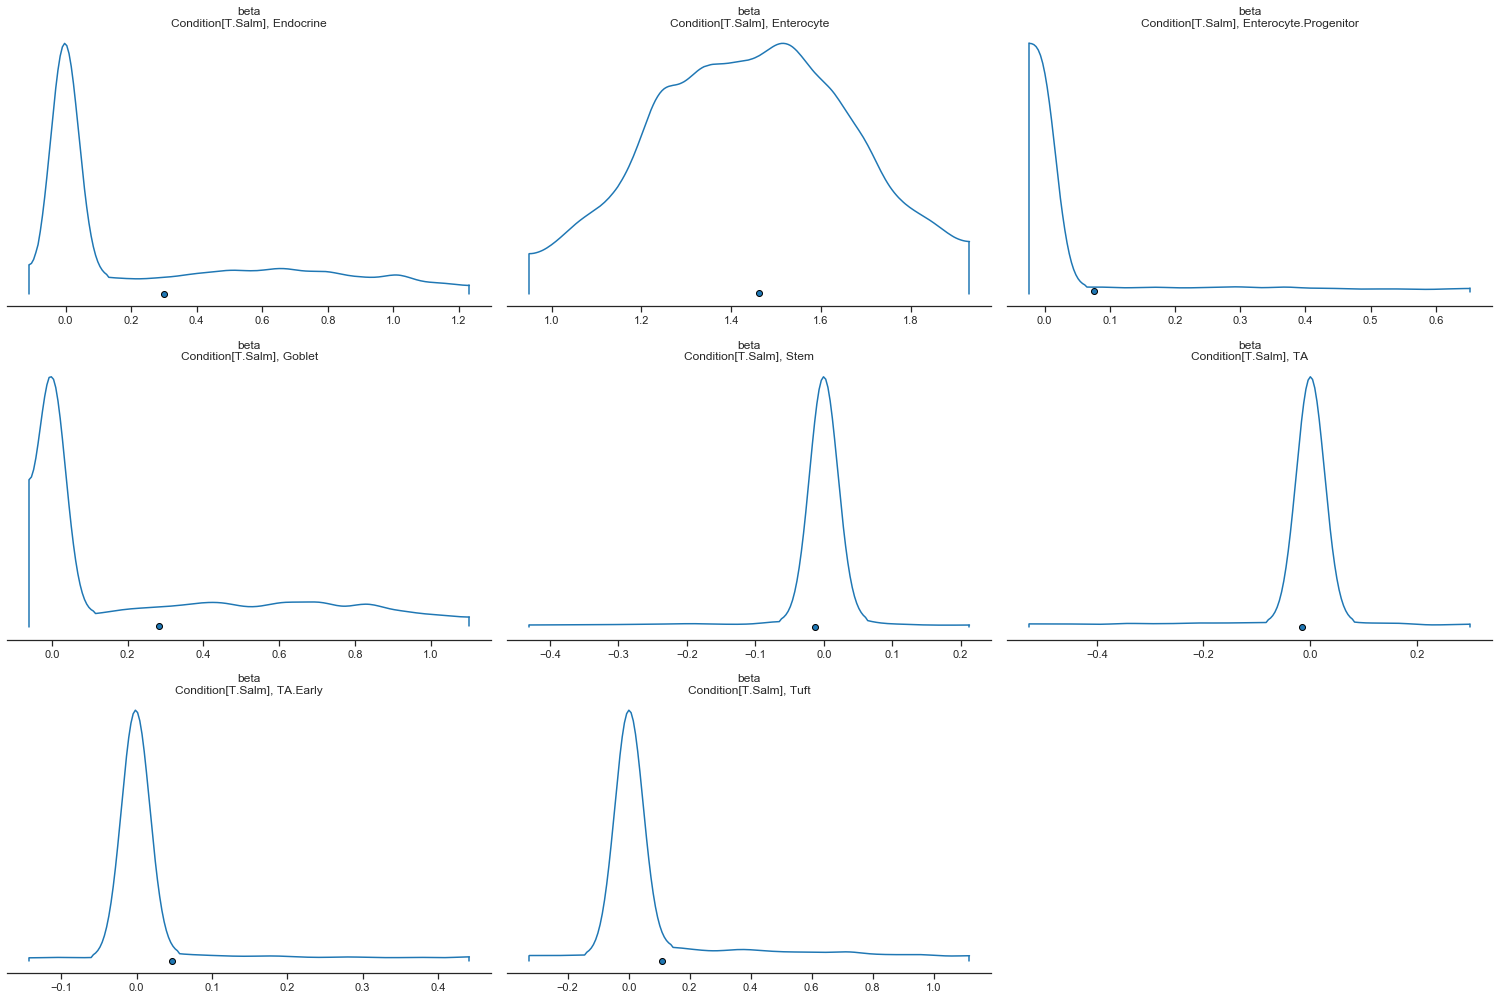

In [19]:
az.plot_density(sim_results, var_names="beta")
plt.show()